In [0]:
!ls

class.csv  sample_data		  test.csv  train.csv
drive	   sample_submission.csv  test.zip  train.zip


In [0]:
# !cp car_clf.h5 /content/drive/'My Drive'/'Colab Notebooks'/Projects/'Kaggle 3rd ML Car CLF'/Model_save/xception_1.h5

In [0]:
!mkdir train
!cp train.zip train/
!unzip train/train.zip -d train

!mkdir test
!cp test.zip test/
!rm train.zip test.zip
!unzip test/test.zip -d test
!rm train/train.zip
!rm test/test.zip

In [0]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing import image
from keras import models, layers 
from keras import callbacks
from keras.applications import Xception
import cv2
import time
from sklearn.model_selection import train_test_split
import keras
import tensorflow as tf

Using TensorFlow backend.


## To use TPU

In [0]:
import os
import pprint
import tensorflow as tf

if 'COLAB_TPU_ADDR' not in os.environ:
  print('ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!')
else:
  tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  print ('TPU address is', tpu_address)

  with tf.Session(tpu_address) as session:
    devices = session.list_devices()
    
  print('TPU devices:')
  pprint.pprint(devices)

ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!


In [0]:
!ls 

class.csv  sample_data		  test	    train
drive	   sample_submission.csv  test.csv  train.csv


In [0]:
# !rm -r /content/train_chop

In [0]:
train_df = pd.read_csv('train.csv')
train_df.head()
train_df['class'] = train_df['class'].astype(str)

In [0]:
img = cv2.imread(f'/content/train/{train_df.iloc[0, 0]}')

In [0]:
img.shape

(500, 700, 3)

In [0]:
def chop_img(data_type, path_df):
  """
     ex) chip_img('trian', train_df)
     
     data_type = train or test as string         
     path_df = train_df or test_df,
     marging = how many pixel left over 
     
     this function create directory as data_type_chop """
  
  if f'{data_type}_chop' in os.listdir('/content/'):
    os.removedirs(f'{data_type}_chop')
  else:
    os.mkdir(f'{data_type}_chop')                                            # make directory
    
  for i in range(len(path_df.img_file)):
    img = cv2.imread(f'/content/{data_type}/{path_df.iloc[i, 0]}')               # load image
    cv2.waitKey(0)
    
    crop_img = img[path_df.iloc[i, 2] : path_df.iloc[i, 4],     # y : y + h
                   path_df.iloc[i,1] : path_df.iloc[i, 3]]     # x : x + w

    cv2.imwrite(f'/content/{data_type}_chop/{path_df.iloc[i,0]}', crop_img)  # save the image
    
    cv2.waitKey(0)

In [0]:
chop_img('train', train_df)

# After chop image

In [0]:
train_df = pd.read_csv('train.csv')
train_df.head()
train_df['class'] = train_df['class'].astype(str)

In [0]:
y = train_df['class']
x = train_df.drop('class', axis = 1)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42, stratify = y)

In [0]:
train_set = pd.concat([X_train, y_train], axis = 1)

In [0]:
validation_set = pd.concat([X_test, y_test], axis=1)

In [0]:
print(train_df.shape)
print('-----------------')
print(train_set.shape)
print(validation_set.shape)

(10016, 6)
-----------------
(8012, 6)
(2004, 6)


In [0]:
train_set.head()

,img_file,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class
3058,train_03059.jpg,20,130,607,421,79
1240,train_01241.jpg,31,114,460,325,78
9584,train_09585.jpg,83,93,686,425,3
6642,train_06643.jpg,271,712,1429,1132,153
7442,train_07443.jpg,24,148,528,343,66


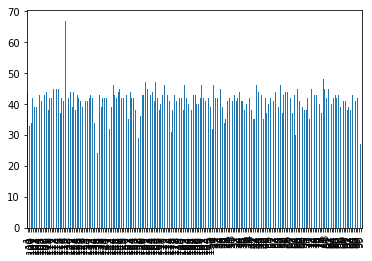

In [0]:
train_set['class'].value_counts().sort_index().plot(kind='bar')

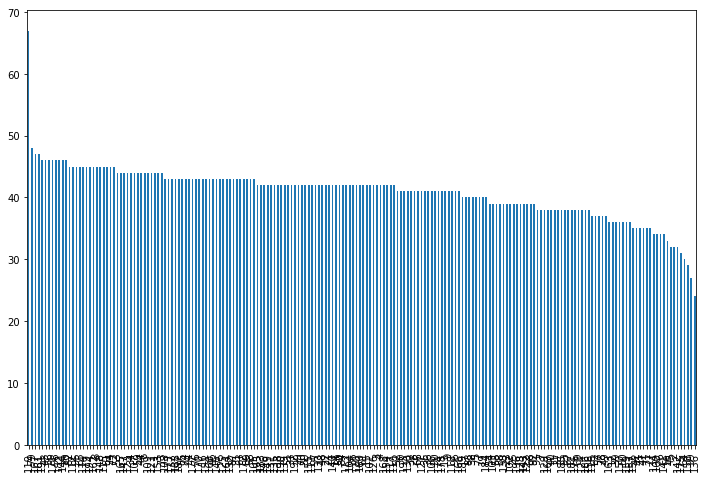

In [0]:
plt.figure(figsize=(12,8))
train_set['class'].value_counts().plot(kind='bar')

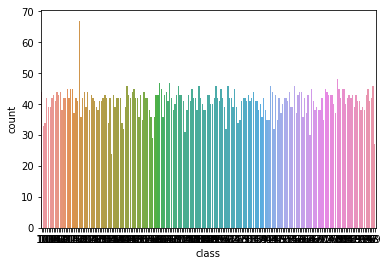

In [0]:
sns.countplot(train_set['class'])

In [0]:
train_set['class'].nunique()

196

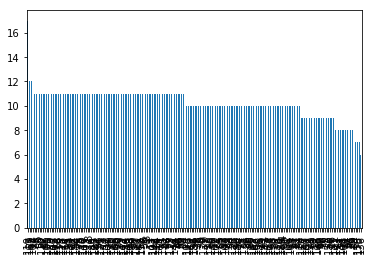

In [0]:
validation_set['class'].value_counts().plot(kind='bar')

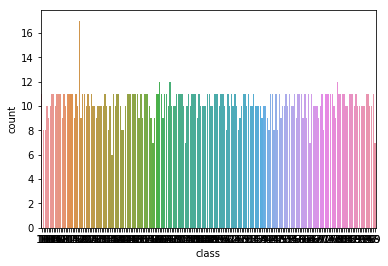

In [0]:
sns.countplot(validation_set['class'])

In [0]:
validation_set['class'].nunique()

196

Split Validation set  0.2 for Hold out set

In [0]:
validation_set.head()

,img_file,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class
6873,train_06874.jpg,26,83,594,361,159
694,train_00695.jpg,100,73,706,516,173
3804,train_03805.jpg,40,66,269,164,14
8307,train_08308.jpg,64,17,442,251,105
3237,train_03238.jpg,74,43,569,407,99


In [0]:
val_x = validation_set.drop('class', axis=1)
val_y = validation_set['class']

In [0]:
X_val, X_hol, y_val, y_hol = train_test_split(val_x, val_y, test_size= 0.2, stratify = val_y)

In [0]:
print(X_val.shape, y_val.shape)

(1603, 5) (1603,)


In [0]:
validation_set = pd.concat([X_val, y_val], axis=1)
hold_out_set = pd.concat([X_hol, y_hol], axis=1)

In [0]:
print(validation_set.shape)
print(hold_out_set.shape)

(1603, 6)
(401, 6)


In [0]:
print('validation : ', validation_set['class'].nunique())
print('hold_out : ', hold_out_set['class'].nunique())

validation :  196
hold_out :  196


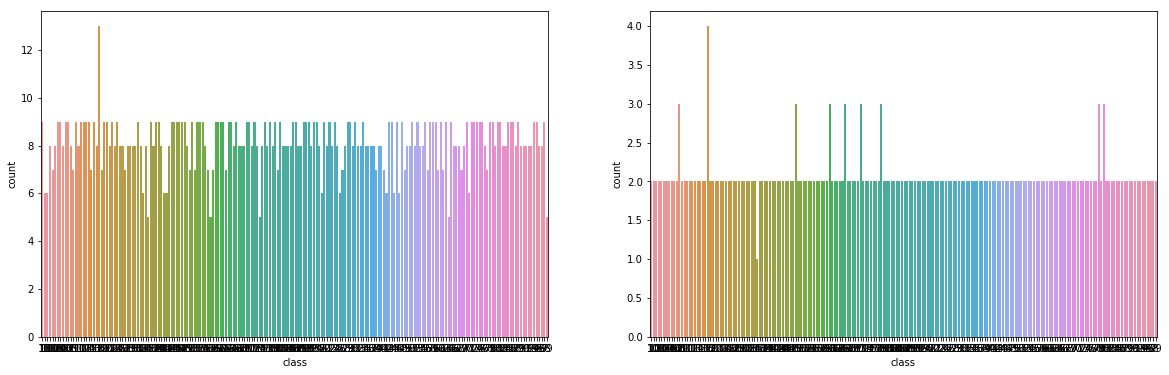

In [0]:
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
sns.countplot('class', data = validation_set)

plt.subplot(1,2,2)
sns.countplot('class', data = hold_out_set)

Spliting Done

In [0]:
print('Training Set, "train_set" :', train_set.shape)
print('Validation Set, "validation_set" :', validation_set.shape)
print('Hold Out Set, "hold_out_set" :', hold_out_set.shape)

Training Set, "train_set" : (8012, 6)
Validation Set, "validation_set" : (1603, 6)
Hold Out Set, "hold_out_set" : (401, 6)


In [0]:
train_set.head()

,img_file,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class
3058,train_03059.jpg,20,130,607,421,79
1240,train_01241.jpg,31,114,460,325,78
9584,train_09585.jpg,83,93,686,425,3
6642,train_06643.jpg,271,712,1429,1132,153
7442,train_07443.jpg,24,148,528,343,66


## Create Generator

In [0]:
datagen = image.ImageDataGenerator(rescale=1./255,
                                  height_shift_range=0.2,
                                  width_shift_range=0.2, 
                                  rotation_range=20,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  vertical_flip=True,
                                  shear_range=0.2)

validation_gen = image.ImageDataGenerator(rescale = 1./255)

holdout_gen = image.ImageDataGenerator(rescale = 1./255)

In [0]:
train_data = datagen.flow_from_dataframe(train_set, '/content/train_chop', x_col='img_file', y_col='class', target_size=(224,224), class_mode='categorical', batch_size=32)

valid_data = validation_gen.flow_from_dataframe(validation_set, '/content/train_chop', x_col = "img_file", y_col = "class", target_size=(224,224), class_mode='categorical', batch_size=32)

holdout_data = holdout_gen.flow_from_dataframe(hold_out_set, '/content/train_chop', x_col = "img_file", y_col = "class", target_size=(224,224), class_mode='categorical', batch_size=32)

Found 8012 validated image filenames belonging to 196 classes.
Found 1603 validated image filenames belonging to 196 classes.
Found 401 validated image filenames belonging to 196 classes.


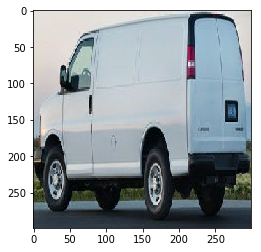

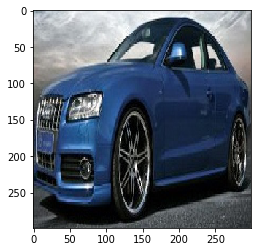

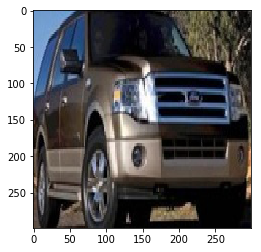

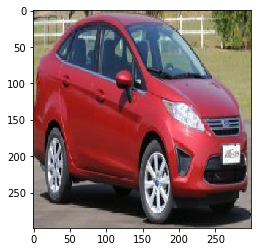

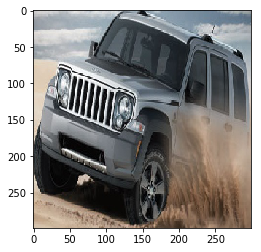

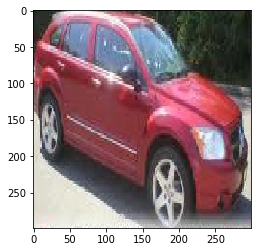

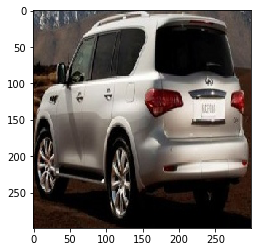

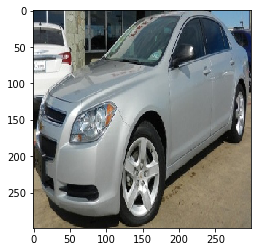

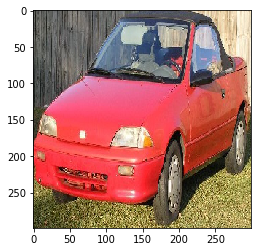

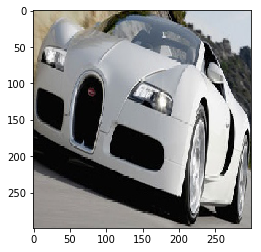

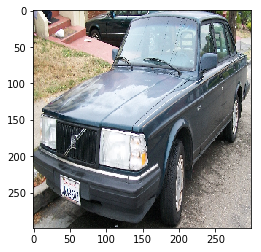

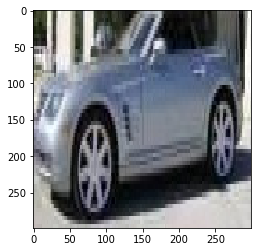

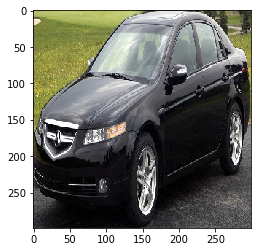

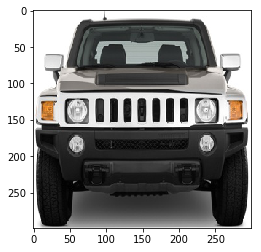

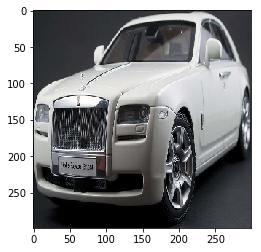

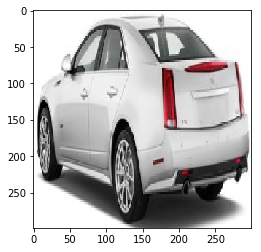

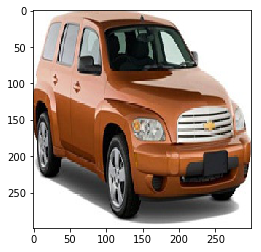

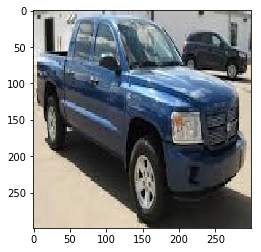

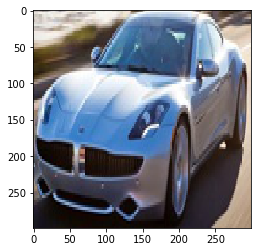

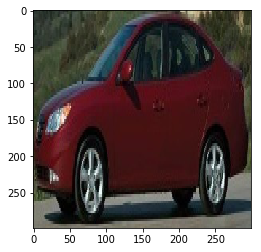

In [0]:
i = 0
for batch in holdout_data:
  img_array = batch[0]
  #print(img_array.shape)
  #print(img_array[i])
  for j in range(len(batch[0])):
    plt.figure(j)
    plt.imshow(img_array[j])
    
  i += 1
  if i % 5:
    break